## Basic Information (Brain Lower Grade Glioma)

Jin Liu

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.datasets import make_friedman1
from sklearn.preprocessing import StandardScaler

## Gene Data

In [2]:
# read the gene expression data: 
# Mount the Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the location of the file
import os
os.chdir('/content/drive/My Drive/prediction_mutation_count')

# Load the TSV file using pandas
import pandas as pd
raw_data_rna = pd.read_csv('data_mrna_seq_v2_rsem.txt', sep='\t')



Mounted at /content/drive


In [3]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


In [4]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")
df_clean.head()

There are 514 samples in total, and there are 20531 genes in total.


Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,0.0,8.7141,22.7523,268.576,845.815,0.0,182.505,0.4196,0.0,0.0,...,80.1636,50.3461,64.1913,523.180,1311.52,0.0000,1495.70,1598.91,1171.810,836.165
TCGA-CS-4941-01,0.0,36.4493,21.1767,156.687,390.269,0.0,325.052,1.7253,0.0,0.0,...,187.2980,110.4210,105.9350,467.564,1226.71,0.3451,1751.21,3889.92,1707.730,1015.530
TCGA-CS-4942-01,0.0,11.8131,11.0242,185.138,621.453,0.0,131.142,0.0000,0.0,0.0,...,120.0310,186.5050,115.2250,454.325,1102.42,0.3460,1586.16,2214.53,1423.880,706.920
TCGA-CS-4943-01,0.0,8.6116,5.0835,269.836,835.729,0.0,83.475,0.3261,0.0,0.0,...,667.4480,1183.6500,89.0183,491.068,1288.32,3.2607,1760.15,2131.55,1916.990,689.321
TCGA-CS-4944-01,0.0,0.0000,30.2610,216.341,812.508,0.0,80.696,0.0000,0.0,0.0,...,57.3244,56.4872,42.3654,323.793,1012.73,0.5044,1225.07,1692.60,729.794,456.941


In [5]:
df_clean.shape

(514, 20531)

## Clinical Patient

In [6]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/prediction_mutation_count')
df_patient = pd.read_csv('data_clinical_sample.txt', sep='\t')
df_sample2 = pd.read_csv('Clinical_Data.tsv', sep='\t')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df_patient.columns = df_patient.iloc[3,:]
df_patient = df_patient.drop([0,1,2,3], axis = 0)
df_patient = df_patient.reset_index().drop(["index"], axis = 1)

In [8]:
df_full_patient = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")

In [9]:
df_full_patient = df_full_patient.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

In [10]:
df_full_patient.columns

Index(['PATIENT_ID', 'SAMPLE_ID', 'ONCOTREE_CODE', 'CANCER_TYPE',
       'CANCER_TYPE_DETAILED', 'TUMOR_TYPE', 'GRADE',
       'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR',
       'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_SOURCE_SITE_CODE',
       'TUMOR_TISSUE_SITE', 'ANEUPLOIDY_SCORE', 'SAMPLE_TYPE',
       'MSI_SCORE_MANTIS', 'MSI_SENSOR_SCORE', 'SOMATIC_STATUS',
       'TMB_NONSYNONYMOUS', 'TISSUE_SOURCE_SITE', 'Mutation Count',
       'Fraction Genome Altered', 'Diagnosis Age', 'MSI MANTIS Score',
       'MSIsensor Score', 'Overall Survival Status', 'Sex',
       'Ethnicity Category', 'Race Category', 'Subtype',
       'Birth from Initial Pathologic Diagnosis Date', 'Buffa Hypoxia Score',
       'Somatic Status'],
      dtype='object')

In [11]:
df_full_patient.shape

(514, 31)

Merging Gene data and Clinical Data

In [12]:
df_clean = df_clean.reset_index().rename(columns={'index': 'Entrez_Gene_Id'})


In [13]:
# Drop duplicate rows based on the Entrez_Gene_Id column
df_clean = df_clean.drop_duplicates(subset='Entrez_Gene_Id')

df_mutation = df_full_patient[['SAMPLE_ID','Mutation Count']]

# Merge the two dataframes on the patient identifier and gene ID columns
merged_df = pd.merge(df_clean, df_mutation, left_on='Entrez_Gene_Id', right_on='SAMPLE_ID').drop('SAMPLE_ID', axis=1)

In [14]:
merged_df

,Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,...,11130,7789,158586,79364,440590,79699,7791,23140,26009,Mutation Count
0,TCGA-CS-4938-01,0.0,8.7141,22.7523,268.576,845.815,0.0,182.505,0.4196,0.0,...,50.3461,64.1913,523.180,1311.520,0.0000,1495.70,1598.91,1171.810,836.165,14.0
1,TCGA-CS-4941-01,0.0,36.4493,21.1767,156.687,390.269,0.0,325.052,1.7253,0.0,...,110.4210,105.9350,467.564,1226.710,0.3451,1751.21,3889.92,1707.730,1015.530,43.0
2,TCGA-CS-4942-01,0.0,11.8131,11.0242,185.138,621.453,0.0,131.142,0.0000,0.0,...,186.5050,115.2250,454.325,1102.420,0.3460,1586.16,2214.53,1423.880,706.920,25.0
3,TCGA-CS-4943-01,0.0,8.6116,5.0835,269.836,835.729,0.0,83.475,0.3261,0.0,...,1183.6500,89.0183,491.068,1288.320,3.2607,1760.15,2131.55,1916.990,689.321,24.0
4,TCGA-CS-4944-01,0.0,0.0000,30.2610,216.341,812.508,0.0,80.696,0.0000,0.0,...,56.4872,42.3654,323.793,1012.730,0.5044,1225.07,1692.60,729.794,456.941,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,TCGA-WY-A85A-01,0.0,5.4526,16.1890,124.919,658.221,0.0,540.512,1.0557,0.0,...,97.1233,53.8401,351.016,1263.130,0.0000,1491.69,1497.49,1556.080,664.555,14.0
510,TCGA-WY-A85B-01,0.0,8.2616,19.7074,133.739,662.651,0.0,610.155,2.1515,0.0,...,349.3980,60.2410,503.012,1347.680,0.8606,1443.63,1574.87,1685.890,836.919,13.0
511,TCGA-WY-A85C-01,0.0,11.5121,18.7291,120.924,524.724,0.0,837.760,3.2693,0.0,...,78.0548,76.4201,530.854,1556.190,2.8606,1855.74,1927.67,2006.130,910.094,27.0
512,TCGA-WY-A85D-01,0.0,5.3895,8.9103,107.254,705.128,0.0,805.720,0.4931,0.0,...,111.9330,35.0099,312.130,1456.110,0.0000,1222.88,1706.11,1429.490,771.203,31.0


Data preprocessing of the final data frame  
- drop NAs  
- Encoding  
- scaling  

In [15]:
# Drop rows with missing values/0/duplicates
merged_df = merged_df.dropna()
merged_df = merged_df.loc[:, merged_df.nunique() > 1]
merged_df = merged_df.loc[:, (merged_df != 0).any()]
merged_df = merged_df.drop('Entrez_Gene_Id',axis = 1)

In [16]:
#encoding
categorical_cols = merged_df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(merged_df, columns=categorical_cols) 

In [17]:
# Convert all feature names to strings
df_encoded.columns = df_encoded.columns.astype(str)



Data split

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target variable (y)
X = df_encoded.drop('Mutation Count', axis=1)
y = df_encoded['Mutation Count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Instantiate a scaler object
scaler = StandardScaler()

# Scale the encoded DataFrame
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
X

,100130426,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
0,0.0,8.7141,22.7523,268.576,845.815,182.505,0.4196,0.0,2.0978,0.4196,...,80.1636,50.3461,64.1913,523.180,1311.520,0.0000,1495.70,1598.91,1171.810,836.165
1,0.0,36.4493,21.1767,156.687,390.269,325.052,1.7253,0.0,3.4507,0.3451,...,187.2980,110.4210,105.9350,467.564,1226.710,0.3451,1751.21,3889.92,1707.730,1015.530
2,0.0,11.8131,11.0242,185.138,621.453,131.142,0.0000,0.0,1.7301,0.3460,...,120.0310,186.5050,115.2250,454.325,1102.420,0.3460,1586.16,2214.53,1423.880,706.920
3,0.0,8.6116,5.0835,269.836,835.729,83.475,0.3261,0.0,1.3043,0.0000,...,667.4480,1183.6500,89.0183,491.068,1288.320,3.2607,1760.15,2131.55,1916.990,689.321
4,0.0,0.0000,30.2610,216.341,812.508,80.696,0.0000,0.0,3.0261,0.0000,...,57.3244,56.4872,42.3654,323.793,1012.730,0.5044,1225.07,1692.60,729.794,456.941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.0,5.4526,16.1890,124.919,658.221,540.512,1.0557,0.0,7.3898,2.1114,...,101.8580,97.1233,53.8401,351.016,1263.130,0.0000,1491.69,1497.49,1556.080,664.555
510,0.0,8.2616,19.7074,133.739,662.651,610.155,2.1515,0.0,11.1876,0.0000,...,241.3380,349.3980,60.2410,503.012,1347.680,0.8606,1443.63,1574.87,1685.890,836.919
511,0.0,11.5121,18.7291,120.924,524.724,837.760,3.2693,0.0,13.4859,0.4087,...,96.6817,78.0548,76.4201,530.854,1556.190,2.8606,1855.74,1927.67,2006.130,910.094
512,0.0,5.3895,8.9103,107.254,705.128,805.720,0.4931,0.0,7.3964,0.4931,...,49.8570,111.9330,35.0099,312.130,1456.110,0.0000,1222.88,1706.11,1429.490,771.203


Applying Lasso regression on the final data frame  
- Do grid search to find the best model
- Evaluate model by its performance on test set

In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
lasso = Lasso(alpha=0.1)

lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)


Mean squared error: 1150314.5851274896


Apply Lasso regression multiple times to see the full picture of feature importance:  
- Because when two or more features are highly correlated, Lasso regularization may arbitrarily choose one of them to keep and one to discard, which can lead to instability and inconsistency in the selected features.

In [21]:
from sklearn.linear_model import LassoCV

In [22]:
lasso = LassoCV(cv=2, random_state=0).fit(X_train, y_train)

In [23]:
print('train: ', lasso.score(X_train, y_train), '\ntest: ', lasso.score(X_test, y_test))

train:  0.4211399733583626 
test:  -0.00973287068730988


In [24]:
# Get the feature importance information with their coefficients
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Print the feature importance information
print('Feature Importance:')
print(feature_importance)

Feature Importance:
      Feature  Coefficient
7991     3219     9.820877
12998   56130     3.611751
7944   343069     3.583266
7990     3218     3.180427
13940   65122     0.736052
...       ...          ...
6740     2539    -0.000000
6739    92579    -0.000000
6738    57818     0.000000
6737     2538    -0.000000
20222   26009     0.000000

[20223 rows x 2 columns]


In [25]:
# Get the top 10 important gene features and their coefficients
top_features = feature_importance.head(10)

# Print the top 10 important gene features and their coefficients
print('Top 10 Important Gene Features:')
print(top_features[['Feature', 'Coefficient']])


Top 10 Important Gene Features:
      Feature  Coefficient
7991     3219     9.820877
12998   56130     3.611751
7944   343069     3.583266
7990     3218     3.180427
13940   65122     0.736052
18430   51605     0.677225
6007   642938     0.393993
11935   55035     0.317411
7987     3215     0.036037
13477    5322    -0.000000


Plot a graph showing feature importances here

Top 10 Important Gene Features:
      Feature  Coefficient
7991     3219     9.820877
12998   56130     3.611751
7944   343069     3.583266
7990     3218     3.180427
13940   65122     0.736052
18430   51605     0.677225
6007   642938     0.393993
11935   55035     0.317411
7987     3215     0.036037
13477    5322    -0.000000


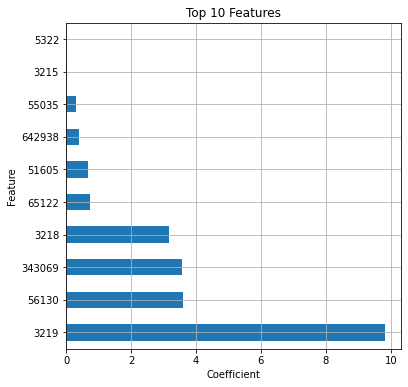

In [26]:
import matplotlib.pyplot as plt

# Get the top 10 important gene features and their coefficients
top_features = feature_importance.head(10)

# Print the top 10 important gene features and their coefficients
print('Top 10 Important Gene Features:')
print(top_features[['Feature', 'Coefficient']])

# Create a bar chart of the top 10 important gene features and their coefficients
fig, ax = plt.subplots(figsize=(6, 6))
top_features.set_index('Feature')['Coefficient'].plot(kind='barh', ax=ax)
ax.set_xlabel('Coefficient')
ax.set_title(f'Top 10 Features')
ax.grid(True)

plt.show()





Try RFE method to see if it differs from results obtained above.

In [27]:
from sklearn.linear_model import Lasso

# Create a Lasso estimator
estimator = Lasso(alpha=0.1)

# Determine the optimal number of features to select using Lasso
estimator.fit(X_train, y_train)
n_features = (estimator.coef_ != 0).sum()

# Create the RFE object and specify the number of features to select
# Use a smaller step size to reduce the number of iterations
selector = RFE(estimator, n_features_to_select=n_features//2, step=0.1)

# Fit the RFE estimator to the data
selector = selector.fit(X_train, y_train)

# Print the selected features
print("Selected features: ", selector.support_)

# Print the feature rankings
print("Feature rankings: ", selector.ranking_)

# Print the train and test scores
train_score = estimator.score(X_train, y_train)
test_score = estimator.score(X_test, y_test)
print("Train score: ", train_score)
print("Test score: ", test_score)

Selected features:  [False  True False ... False False False]
Feature rankings:  [11  1  2 ...  6  7  3]
Train score:  0.9981409590522372
Test score:  -0.0109213697742776


In [28]:
import numpy as np

# Get the indices of the most important features
important_feature_indices = np.argsort(selector.ranking_)[:10]

# Print the names of the most important features
important_feature_names = X.columns[important_feature_indices]
print("The first 10 most important features are:", important_feature_names)


The first 10 most important features are: Index(['10240', '5671', '10234', '341277', '79973', '10795', '58503', '122665',
       '55888', '376412'],
      dtype='object')


In [29]:
# Get the top 10 important gene features and their coefficients
important_feature_indices = np.argsort(selector.ranking_)[:10]
important_feature_names = X.columns[important_feature_indices]
important_feature_coefficients = estimator.coef_[important_feature_indices]

# Create a dataframe with the top 10 features and their coefficients
feature_importance = pd.DataFrame({'Feature': important_feature_names, 'Coefficient': important_feature_coefficients})

# Sort the dataframe by coefficient values in descending order
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

# Print the top 10 important gene features and their coefficients
top_features = feature_importance.head(10)
print('Top 10 Important Gene Features:')
print(top_features[['Feature', 'Coefficient']])



Top 10 Important Gene Features:
  Feature  Coefficient
3  341277     1.722621
5   10795     0.938393
2   10234     0.701098
4   79973     0.639684
6   58503     0.562195
0   10240     0.432273
9  376412    -0.388985
1    5671    -0.721075
7  122665    -0.744435
8   55888    -1.225921


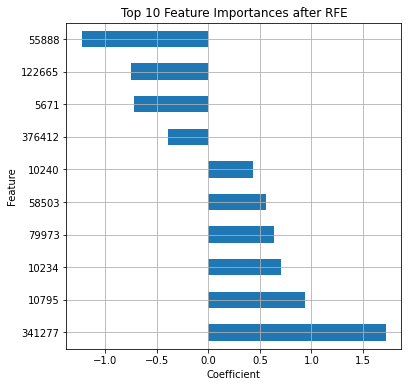

In [30]:
import matplotlib.pyplot as plt

# Get the top 10 important gene features and their coefficients
important_feature_indices = np.argsort(selector.ranking_)[:10]
important_feature_names = X.columns[important_feature_indices]
important_feature_coefficients = estimator.coef_[important_feature_indices]

# Create a dataframe with the top 10 features and their coefficients
feature_importance = pd.DataFrame({'Feature': important_feature_names, 'Coefficient': important_feature_coefficients})

# Sort the dataframe by coefficient values in descending order
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

# Select the top 10 important gene features
top_features = feature_importance.head(10)

# Create a horizontal bar chart with the top 10 features and their coefficients
_, ax = plt.subplots(figsize=(6, 6))
alpha = round(estimator.alpha, 2)
top_features.plot.barh(x='Feature', y='Coefficient', ax=ax, legend=False)
ax.set_xlabel("Coefficient")
ax.set_title(f'Top 10 Feature Importances after RFE')
ax.grid(True)

plt.show()



In [31]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Instantiate an ElasticNetCV estimator with cross-validation
elastic_net = ElasticNetCV(cv=5, l1_ratio=0.5)

# Fit the estimator to the data
elastic_net.fit(X_train, y_train)

# Print the selected features
print("Selected features: ", elastic_net.coef_ != 0)

y_pred = elastic_net.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

# Get the feature rankings
feature_rankings = elastic_net.coef_

# Combine the feature names and their rankings into a list of tuples
features = zip(X.columns, feature_rankings)

# Sort the list by the ranking
sorted_features = sorted(features, key=lambda x: abs(x[1]), reverse=True)



Selected features:  [False False False ... False False False]
Mean squared error: 1147310.4520686204


In [32]:
print("Feature rankings:")
for i, (name, rank) in enumerate(sorted_features[:10]):
    print(f"{i+1}. {name}: {rank}")


Feature rankings:
1. 56130: 2.479337698771636
2. 343069: 2.1906927921706547
3. 5913: 1.3352452622061608
4. 3219: 1.3079370067577938
5. 3215: 1.2983862998147446
6. 3216: 1.2776543161843146
7. 3218: 1.2760699925488885
8. 158833: 1.2418695290856334
9. 65122: 1.2329131034115364
10. 642938: 1.1953989492922514


Top 10 Important Gene Features:
  Feature  Coefficient
0   56130     2.479338
1  343069     2.190693
2    5913     1.335245
3    3219     1.307937
4    3215     1.298386
5    3216     1.277654
6    3218     1.276070
7  158833     1.241870
8   65122     1.232913
9  642938     1.195399


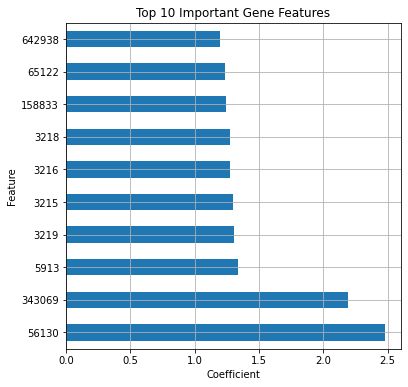

In [33]:
import matplotlib.pyplot as plt

# Get the top 10 important gene features and their coefficients
top_features = pd.DataFrame(sorted_features[:10], columns=['Feature', 'Coefficient'])

# Print the top 10 important gene features and their coefficients
print('Top 10 Important Gene Features:')
print(top_features)

# Create a bar chart of the top 10 important gene features and their coefficients
fig, ax = plt.subplots(figsize=(6, 6))
top_features.set_index('Feature')['Coefficient'].plot(kind='barh', ax=ax)
ax.set_xlabel('Coefficient')
ax.set_title('Top 10 Important Gene Features')
ax.grid(True)

plt.show()


In [34]:
import pandas as pd

# Lasso results
lasso_df = pd.DataFrame({
    'Feature': [3219, 56130, 343069, 3218, 65122, 51605, 642938, 55035, 3215, 5322],
    'Coefficient (Lasso)': [9.820877, 3.611751, 3.583266, 3.180427, 0.736052, 0.677225, 0.393993, 0.317411, 0.036037, -0.000000]
})

# ElasticNetCV results
elastic_df = pd.DataFrame({
    'Feature': [56130, 343069, 5913, 3219, 3215, 3216, 3218, 158833, 65122, 642938],
    'Coefficient (ElasticNetCV)': [2.479337698771636, 2.1906927921706547, 1.3352452622061608, 1.3079370067577938, 1.2983862998147446, 1.2776543161843146, 1.2760699925488885, 1.2418695290856334, 1.2329131034115364, 1.1953989492922514]
})

# Merge dataframes
merged_df = pd.merge(lasso_df, elastic_df, on='Feature', how='outer')

# Set feature as index
merged_df.set_index('Feature', inplace=True)

# Highlight important features
def highlight_important(s):
    if s['Coefficient (Lasso)'] > 1 and s['Coefficient (ElasticNetCV)'] > 1:
        return ['background-color: yellow'] * 2
    else:
        return [''] * 2

# Apply highlighting function
merged_df.style.apply(highlight_important, axis=1)



,Coefficient (Lasso),Coefficient (ElasticNetCV)
Feature,,
3219,9.820877,1.307937
56130,3.611751,2.479338
343069,3.583266,2.190693
3218,3.180427,1.276070
65122,0.736052,1.232913
51605,0.677225,nan
642938,0.393993,1.195399
55035,0.317411,nan
3215,0.036037,1.298386


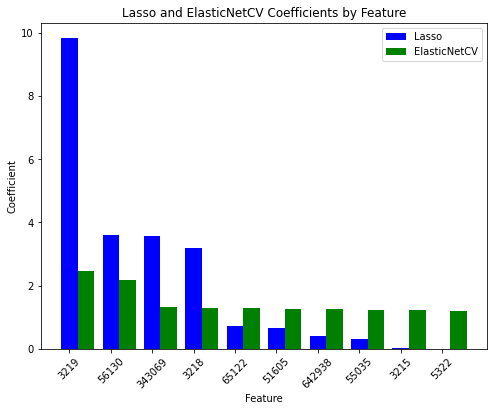

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Set up data for plotting
lasso_features = lasso_df['Feature']
lasso_coefs = lasso_df['Coefficient (Lasso)']
elastic_features = elastic_df['Feature']
elastic_coefs = elastic_df['Coefficient (ElasticNetCV)']

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(len(lasso_features)), lasso_coefs, width=0.4, label='Lasso', color='b')
ax.bar(np.arange(len(elastic_features))+0.4, elastic_coefs, width=0.4, label='ElasticNetCV', color='g')
ax.set_xticks(np.arange(len(lasso_features)))
ax.set_xticklabels(lasso_features, rotation=45)
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient')
ax.set_title('Lasso and ElasticNetCV Coefficients by Feature')

# Highlight top five important features with arrows
highlight_indices = [0, 1, 2, 3, 4]
for index in highlight_indices:
    feature = lasso_features[index]
    lasso_coef = lasso_coefs[index]
    if feature in elastic_features:
        elastic_coef = elastic_coefs[elastic_features == feature][0]
        x = index
        y = max(lasso_coef, elastic_coef)
        ax.annotate(f'{feature}', xy=(x, y), xytext=(x, y+0.5), ha='center', fontsize=10, arrowprops=dict(facecolor='red', shrink=0.05))

plt.legend()
plt.show()




In [36]:
from tabulate import tabulate

# Define the data
data = [
    ['Feature', 'Gene Name', 'Protein', 'Protein Class', 'Prognostic Summary'],
    ['3219', 'HOXB9', 'Homeobox B9', 'Transcription factors', 'Prognostic marker in head and neck cancer (unfavorable) and endometrial cancer (unfavorable)'],
    ['56130', 'PCDHB6', 'Protocadherin beta 6', 'None', 'Prognostic marker in renal cancer (unfavorable)'],
    ['343069', 'HNRNPCL1', 'Heterogeneous nuclear ribonucleoprotein C like 1', 'None', 'Gene product is not prognostic'],
    ['3218', 'HOXB8', 'Homeobox B8', 'Transcription factors', 'Prognostic marker in renal cancer (favorable)'],
    ['65122', 'PRAMEF2', 'PRAME family member 2', 'None', 'Gene product is not prognostic']
]

# Create the table using tabulate
table = tabulate(data, headers='firstrow', tablefmt='grid')

# Print the table
print(table)




+-----------+-------------+--------------------------------------------------+-----------------------+----------------------------------------------------------------------------------------------+
|   Feature | Gene Name   | Protein                                          | Protein Class         | Prognostic Summary                                                                           |
+===========+=============+==================================================+=======================+==============================================================================================+
|      3219 | HOXB9       | Homeobox B9                                      | Transcription factors | Prognostic marker in head and neck cancer (unfavorable) and endometrial cancer (unfavorable) |
+-----------+-------------+--------------------------------------------------+-----------------------+----------------------------------------------------------------------------------------------+
|     5613